In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import scipy.stats as sps
from sklearn.mixture import GaussianMixture
from tqdm.notebook import tqdm


In [2]:
def plot_insights(directories):
    if isinstance(directories, str):
        directories = [directories] # Handle single directory string input

    all_results = {}
    single_dir_data_for_hist = {}

    for directory in directories:
        data = np.load(f"outputs/{directory}/losses.npy")
        epochs = 0
        for i in range(data.shape[0]):
            if np.count_nonzero(data[i]) > 0:
                epochs += 1
        data = data[:epochs, :]

        true_labels = np.load(f'outputs/{directory}/true_labels.npy')
        corrupted_labels = np.load(f'outputs/{directory}/corrupted_labels.npy')
        labels_history = np.load(f'outputs/{directory}/labels_history.npy')[:epochs, :]
        val_accuracies = np.load(f'outputs/{directory}/val_accuracies.npy')[:epochs]
        train_accuracies = np.load(f'outputs/{directory}/train_accuracies.npy')[:epochs]
        train_predictions = np.load(f'outputs/{directory}/train_predictions.npy')[:epochs, :]
        is_corrupted = labels_history != true_labels[None, :]

        wds = []
        intersections = []
        gmm_diffs = []
        corr_pred_precisions = []
        corr_pred_recalls = []

        corrupted_fraction = (labels_history == true_labels).sum(axis=1) / labels_history.shape[1]
        corrupted_fraction = 1 - corrupted_fraction

        if len(directories) == 1:
            single_dir_data_for_hist['data'] = data
            single_dir_data_for_hist['epochs'] = epochs
            single_dir_data_for_hist['is_corrupted'] = is_corrupted

        for epoch in tqdm(range(epochs), desc=f"Processing {directory}", leave=False):
            scaled_data = np.clip(data[epoch, :], 0, np.quantile(data[epoch, :], 0.99))
            std_val = np.std(scaled_data)
            if std_val > 1e-9:
                 scaled_data = (scaled_data - np.mean(scaled_data)) / std_val
            else:
                 scaled_data = scaled_data - np.mean(scaled_data)

            clean_scaled = scaled_data[~is_corrupted[epoch]]
            corrupted_scaled = scaled_data[is_corrupted[epoch]]
            if clean_scaled.size > 0 and corrupted_scaled.size > 0:
                 wd = wasserstein_distance(clean_scaled, corrupted_scaled)
            else:
                 wd = np.nan
            wds.append(wd)

            clipped_data = np.clip(
                scaled_data,
                np.quantile(scaled_data, 0.01),
                np.quantile(scaled_data, 0.99)
            )
            min_clip, max_clip = min(clipped_data), max(clipped_data)
            if max_clip <= min_clip:
                 bins = np.array([min_clip, min_clip + 1e-6])
            else:
                 bins = np.linspace(min_clip, max_clip, 50)

            h_clean = np.histogram(clipped_data[~is_corrupted[epoch]], bins=bins, density=True)[0]
            h_corrupted = np.histogram(clipped_data[is_corrupted[epoch]], bins=bins, density=True)[0]
            intersection = np.sum(np.minimum(h_clean, h_corrupted))
            sum_h_clean = np.sum(h_clean)
            intersection = intersection / sum_h_clean if sum_h_clean > 1e-9 else np.nan
            intersections.append(intersection)

            no_outliers_data = scaled_data[scaled_data < np.quantile(scaled_data, 0.95)]

            gmm_intersection = np.nan
            gmm = GaussianMixture(n_components=2, covariance_type='diag')
            gmm.fit(no_outliers_data.reshape(-1, 1))
            covs = gmm.covariances_
            mu1, sigma1 = gmm.means_[0][0], np.sqrt(covs[0][0])
            mu2, sigma2 = gmm.means_[1][0], np.sqrt(covs[1][0])
            if mu1 > mu2:
                mu1, sigma1, mu2, sigma2 = mu2, sigma2, mu1, sigma1

            pdf1 = sps.norm(mu1, sigma1).pdf(bins)
            pdf2 = sps.norm(mu2, sigma2).pdf(bins)
            
            sum_pdf1 = np.sum(pdf1)
            gmm_intersection = np.sum(np.minimum(pdf1, pdf2)) / sum_pdf1 if sum_pdf1 > 1e-9 else np.nan

            gmm_diffs.append(gmm_intersection)

        avg_loss_corrupted_list = []
        avg_loss_clean_list = []
        for ep in range(epochs):
             clean_losses_ep = data[ep, ~is_corrupted[ep]]
             corrupted_losses_ep = data[ep, is_corrupted[ep]]
             avg_loss_clean_list.append(np.mean(clean_losses_ep) if clean_losses_ep.size > 0 else np.nan)
             avg_loss_corrupted_list.append(np.mean(corrupted_losses_ep) if corrupted_losses_ep.size > 0 else np.nan)


        initial_is_corrupted = is_corrupted[0]
        sum_initial_corrupted = initial_is_corrupted.sum()
        if sum_initial_corrupted > 0:
            misclassified = (
                train_predictions == corrupted_labels.reshape(1, -1)
            )[:, initial_is_corrupted].sum(axis=1) / sum_initial_corrupted
            correct = (
                train_predictions == true_labels.reshape(1, -1)
            )[:, initial_is_corrupted].sum(axis=1) / sum_initial_corrupted
            incorrect = (
                (train_predictions != true_labels.reshape(1, -1)) & (train_predictions != corrupted_labels.reshape(1, -1))
            )[:, initial_is_corrupted].sum(axis=1) / sum_initial_corrupted
        else:
            nan_array = np.full(epochs, np.nan)
            misclassified, correct, incorrect = nan_array, nan_array, nan_array


        all_results[directory] = {
            'val_accuracies': val_accuracies,
            'corrupted_fraction': corrupted_fraction,
            'avg_loss_corrupted': np.array(avg_loss_corrupted_list),
            'avg_loss_clean': np.array(avg_loss_clean_list),
            'gmm_diffs': np.array(gmm_diffs),
            'train_accuracies': train_accuracies,
            'misclassified': misclassified,
            'correct': correct,
            'incorrect': incorrect,
            'wds': np.array(wds),
            'intersections': np.array(intersections),
            'corr_pred_precisions': np.array(corr_pred_precisions),
            'corr_pred_recalls': np.array(corr_pred_recalls)
        }

    if len(directories) == 1:
        directory = directories[0]
        data = single_dir_data_for_hist['data']
        epochs = single_dir_data_for_hist['epochs']
        is_corrupted = single_dir_data_for_hist['is_corrupted']

        k, m = 5, 4
        fig_hist, ax_hist = plt.subplots(k, m, figsize=(12, 8))
        handles, labels = None, None
        for i in range(k):
            for j in range(m):
                n = i * m + j
                epoch = min(int(n * (epochs / (k * m))), epochs - 1)
                clipped_data = data[epoch, :].copy()
                clipped_data = np.clip(clipped_data, 0, np.quantile(clipped_data, 0.99))
                std_val = np.std(clipped_data)
                if std_val > 1e-9:
                    clipped_data = (clipped_data - np.mean(clipped_data)) / std_val
                else:
                    clipped_data = clipped_data - np.mean(clipped_data)


                min_clip, max_clip = min(clipped_data), max(clipped_data)
                if max_clip <= min_clip:
                     bins = np.array([min_clip, min_clip + 1e-6])
                else:
                     bins = np.linspace(min_clip, max_clip, 50)

                h1, _, _ = ax_hist[i, j].hist(clipped_data[~is_corrupted[epoch]], bins=bins, alpha=0.5, label='Clean Labels', density=True)
                h2, _, _ = ax_hist[i, j].hist(clipped_data[is_corrupted[epoch]], bins=bins, alpha=0.5, label='Corrupted Labels', density=True)
                ax_hist[i, j].set_title(f'Epoch {epoch}')

                all_h = np.concatenate((h1, h2))
                if all_h.size > 0:
                    q4 = np.quantile(all_h, 0.75)
                    q1 = np.quantile(all_h, 0.25)
                    iqr = q4 - q1
                    upper_bound = q4 + 10 * iqr
                    max_h = max(h1.max(), h2.max()) if h1.size > 0 and h2.size > 0 else (h1.max() if h1.size > 0 else (h2.max() if h2.size > 0 else 0))
                    ax_hist[i, j].set_ylim(0, min(upper_bound, max_h * 1.1))
                else:
                    ax_hist[i, j].set_ylim(0, 1)

                if i == 0 and j == 0:
                    handles, labels = ax_hist[i, j].get_legend_handles_labels()

                no_outliers_data = clipped_data[clipped_data < np.quantile(clipped_data, 0.975)]
   
                gmm = GaussianMixture(n_components=2, covariance_type='diag')
                gmm.fit(no_outliers_data.reshape(-1, 1))
                covs = gmm.covariances_
                mu1, sigma1 = gmm.means_[0][0], np.sqrt(covs[0][0])
                mu2, sigma2 = gmm.means_[1][0], np.sqrt(covs[1][0])
                if mu1 > mu2:
                    mu1, sigma1, mu2, sigma2 = mu2, sigma2, mu1, sigma1

                x = np.linspace(min(clipped_data), max(clipped_data), 100)
                ax_hist[i, j].plot(x, sps.norm(mu1, sigma1).pdf(x), color='blue')
                ax_hist[i, j].plot(x, sps.norm(mu2, sigma2).pdf(x), color='red')
                

        if handles and labels:
             fig_hist.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.01))

        plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.95])
        plt.subplots_adjust(wspace=0.2, hspace=0.5)
        plt.show()


    _, ax = plt.subplots(4, 2, figsize=(10, 13))

    for dir_name, results in all_results.items():
        ax[0, 0].plot(results['val_accuracies'], label=dir_name)
        ax[0, 1].plot(results['corrupted_fraction'], label=dir_name)
        ax[1, 0].plot(results['avg_loss_corrupted'], label=f'{dir_name} Corrupted')
        ax[1, 0].plot(results['avg_loss_clean'], label=f'{dir_name} Clean', linestyle='--')
        ax[1, 1].plot(results['gmm_diffs'], label=dir_name)
        ax[2, 0].plot(results['train_accuracies'], label=dir_name)
        ax[2, 1].plot(results['misclassified'], label=f'{dir_name} Memorized')
        ax[2, 1].plot(results['correct'], label=f'{dir_name} Correct', linestyle='--')
        ax[2, 1].plot(results['incorrect'], label=f'{dir_name} Incorrect', linestyle=':')
        ax[3, 0].plot(results['wds'], label=dir_name)
        ax[3, 1].plot(results['intersections'], label=dir_name)

    ax[0, 0].set_title('Validation Accuracy')
    ax[0, 0].set_xlabel('Epoch')
    ax[0, 0].set_ylabel('Accuracy')
    if len(directories) > 1: ax[0, 0].legend()

    ax[0, 1].set_title('Corrupted Fraction')
    ax[0, 1].set_xlabel('Epoch')
    ax[0, 1].set_ylabel('Fraction')
    ax[0, 1].set_yticks(np.arange(
        0,
        np.max([results['corrupted_fraction'].max() for results in all_results.values()]) + 0.05,
        step=0.05
    ))
    if len(directories) > 1: ax[0, 1].legend()

    ax[1, 0].set_title('Average Loss')
    ax[1, 0].set_xlabel('Epoch')
    ax[1, 0].set_ylabel('Loss')
    ax[1, 0].legend(fontsize='small')

    ax[1, 1].set_title('GMM Intersection')
    ax[1, 1].set_xlabel('Epoch')
    ax[1, 1].set_ylabel('Intersection')
    if len(directories) > 1: ax[1, 1].legend()

    ax[2, 0].set_title('Train Accuracy')
    ax[2, 0].set_xlabel('Epoch')
    ax[2, 0].set_ylabel('Accuracy')
    if len(directories) > 1: ax[2, 0].legend()

    ax[2, 1].set_title('Train Predictions on corrupted data')
    ax[2, 1].set_xlabel('Epoch')
    ax[2, 1].set_ylabel('Fraction')
    ax[2, 1].legend(fontsize='small')

    ax[3, 0].set_title('Wasserstein Distance Clean/Corrupted')
    ax[3, 0].set_ylabel('Wasserstein Distance')
    ax[3, 0].set_xlabel('Epoch')
    if len(directories) > 1: ax[3, 0].legend()

    ax[3, 1].set_title('Intersection of Histograms')
    ax[3, 1].set_ylabel('Intersection')
    ax[3, 1].set_xlabel('Epoch')
    if len(directories) > 1: ax[3, 1].legend()

    plt.tight_layout()
    plt.show()

## MNIST

### Asymmetric noise

Processing adamw_mnist_flip_gmm:   0%|          | 0/48 [00:00<?, ?it/s]

Processing adversarial_mnist_flip_gmm:   0%|          | 0/48 [00:00<?, ?it/s]

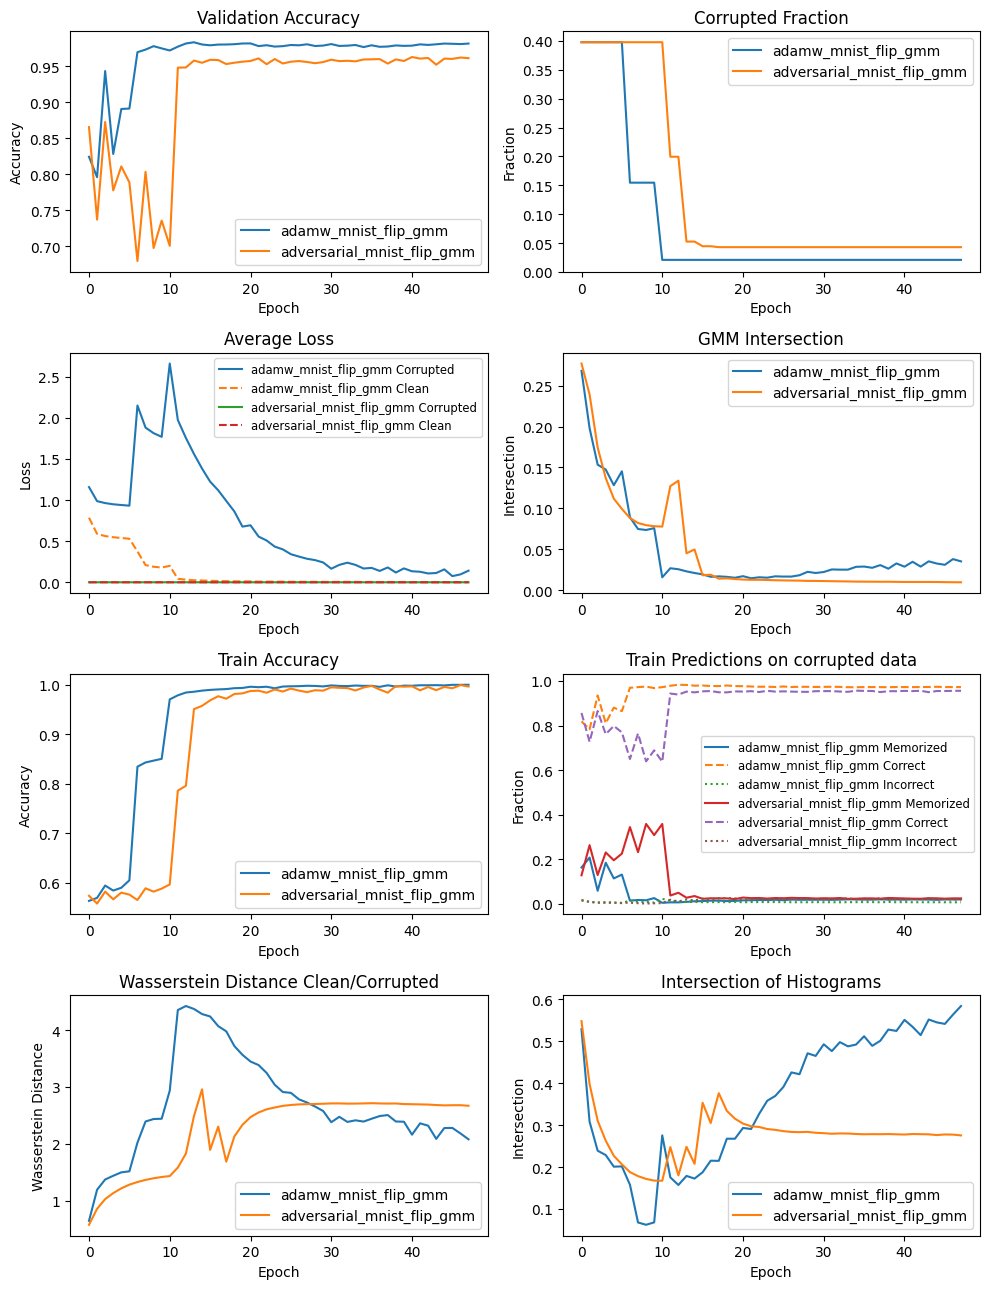

In [3]:
plot_insights(['adamw_mnist_flip_gmm', 'adversarial_mnist_flip_gmm'])

### Uniform noise

Processing adamw_mnist_unif_gmm:   0%|          | 0/48 [00:00<?, ?it/s]

Processing adversarial_mnist_unif_gmm:   0%|          | 0/48 [00:00<?, ?it/s]

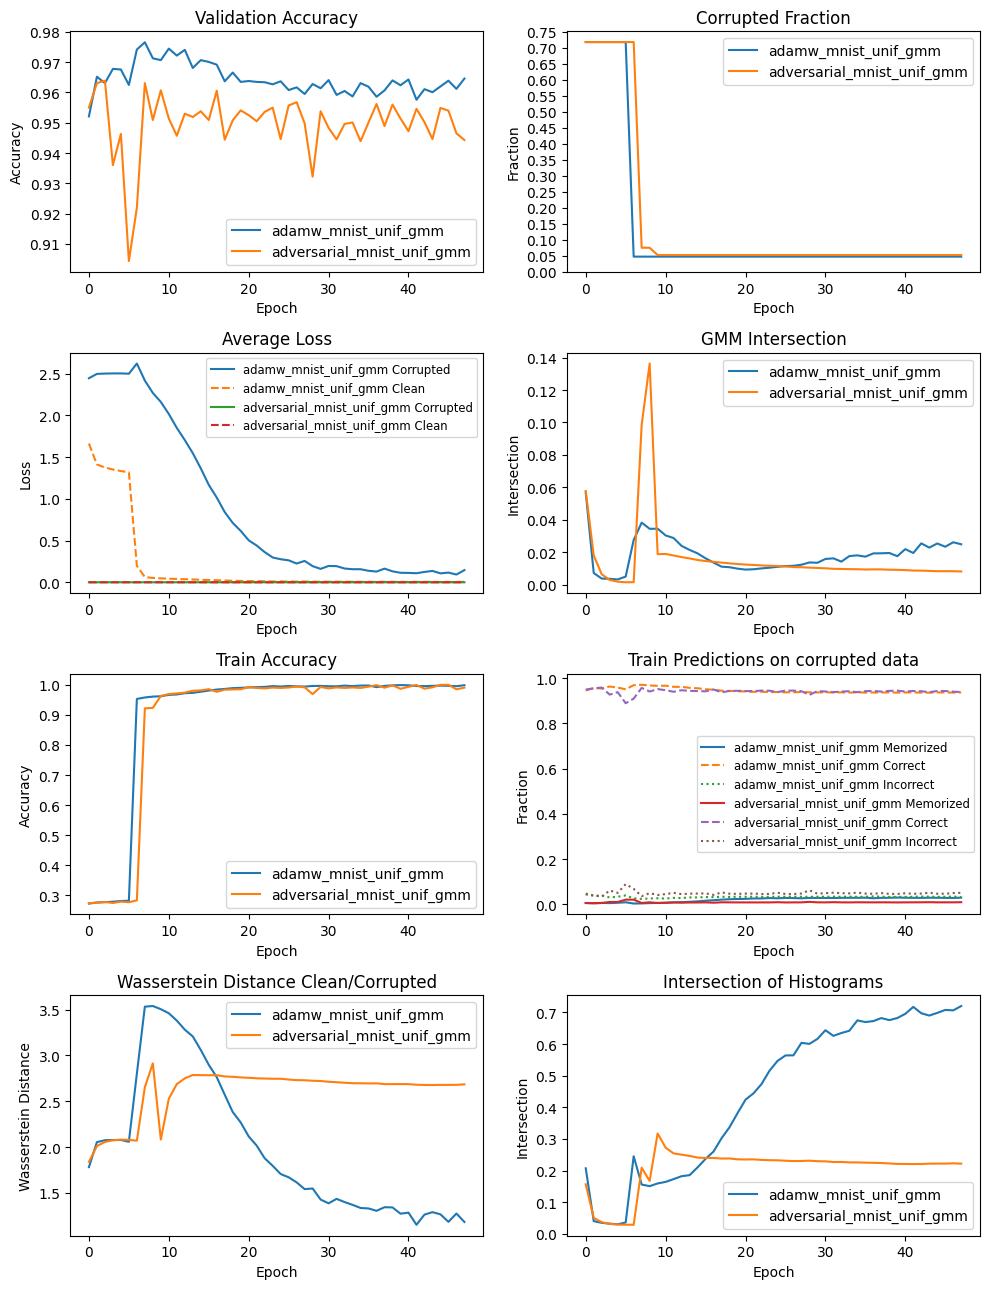

In [4]:
plot_insights(['adamw_mnist_unif_gmm', 'adversarial_mnist_unif_gmm'])

## CIFAR

Processing adamw_cifar_unif_base:   0%|          | 0/48 [00:00<?, ?it/s]

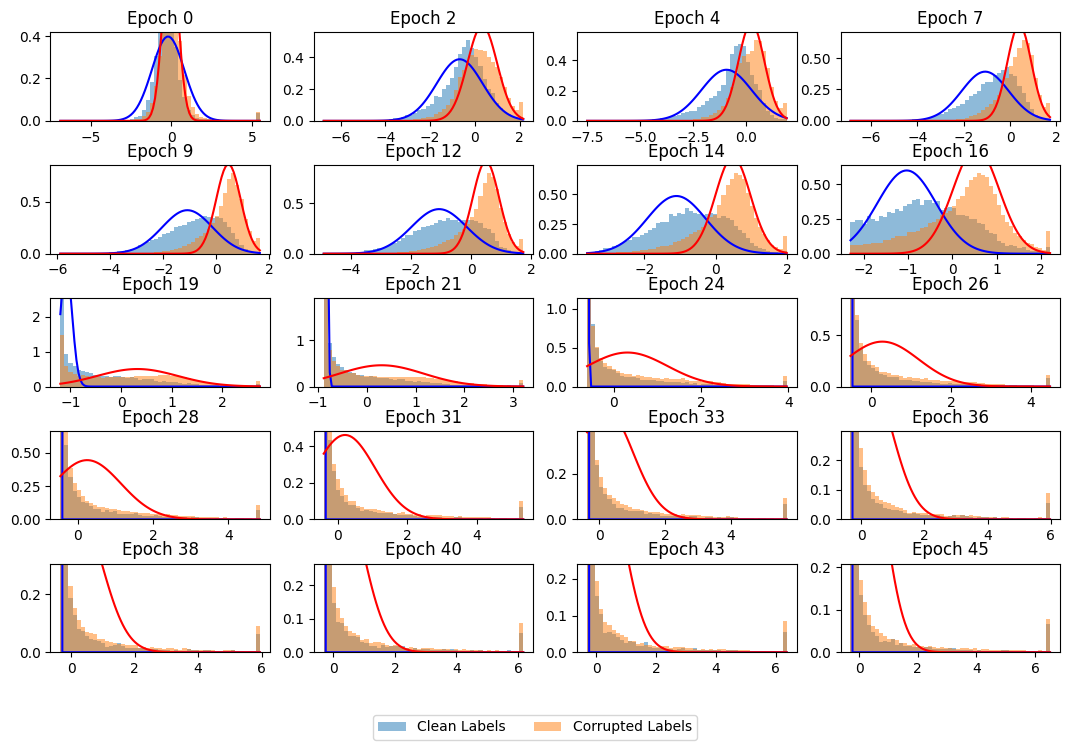

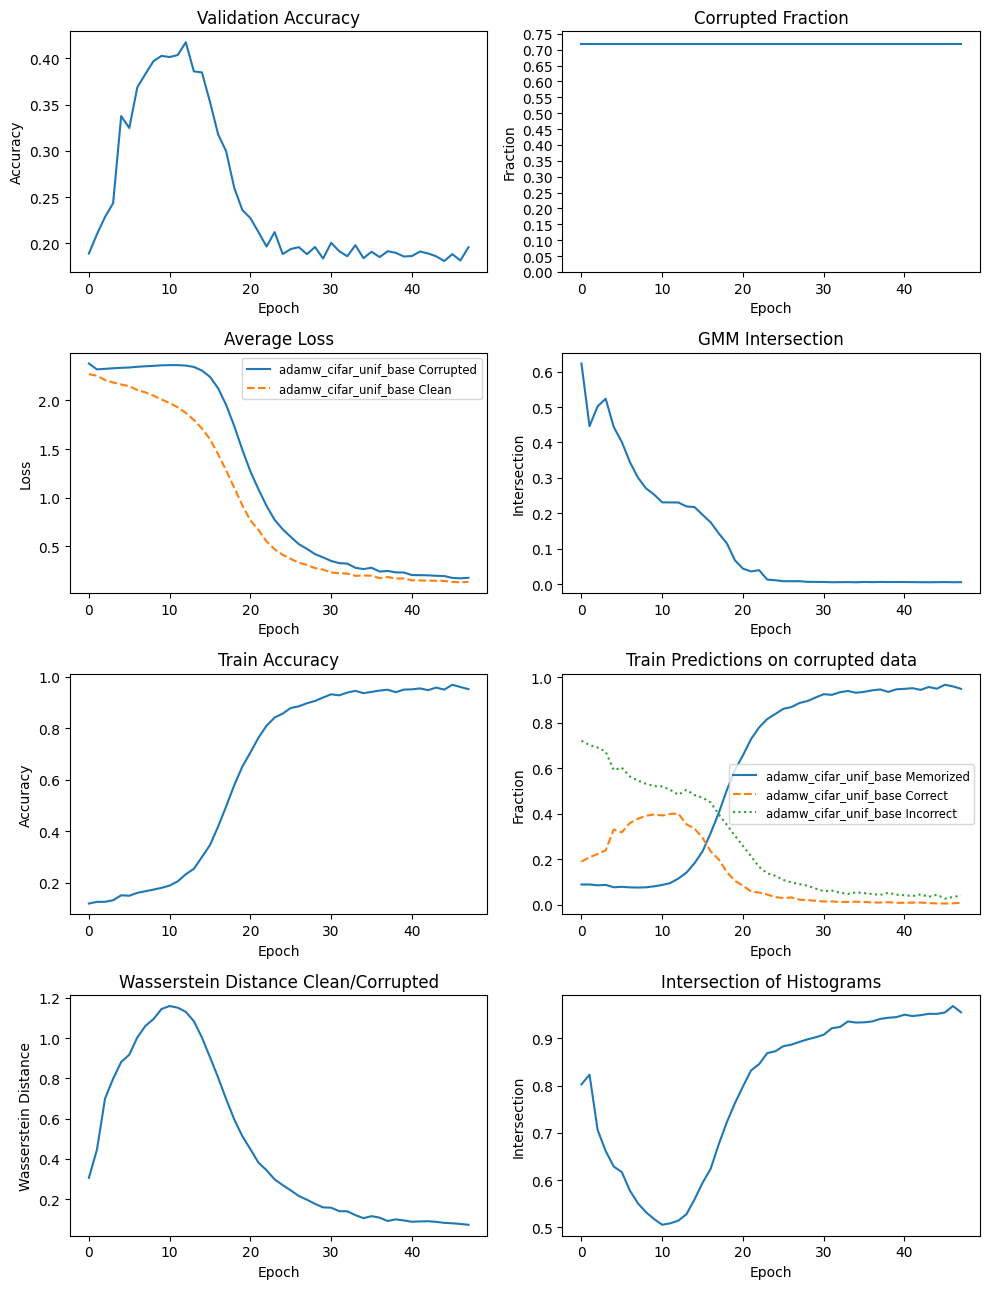

In [5]:
plot_insights('adamw_cifar_unif_base')

Processing adversarial_cifar_unif_base:   0%|          | 0/48 [00:00<?, ?it/s]

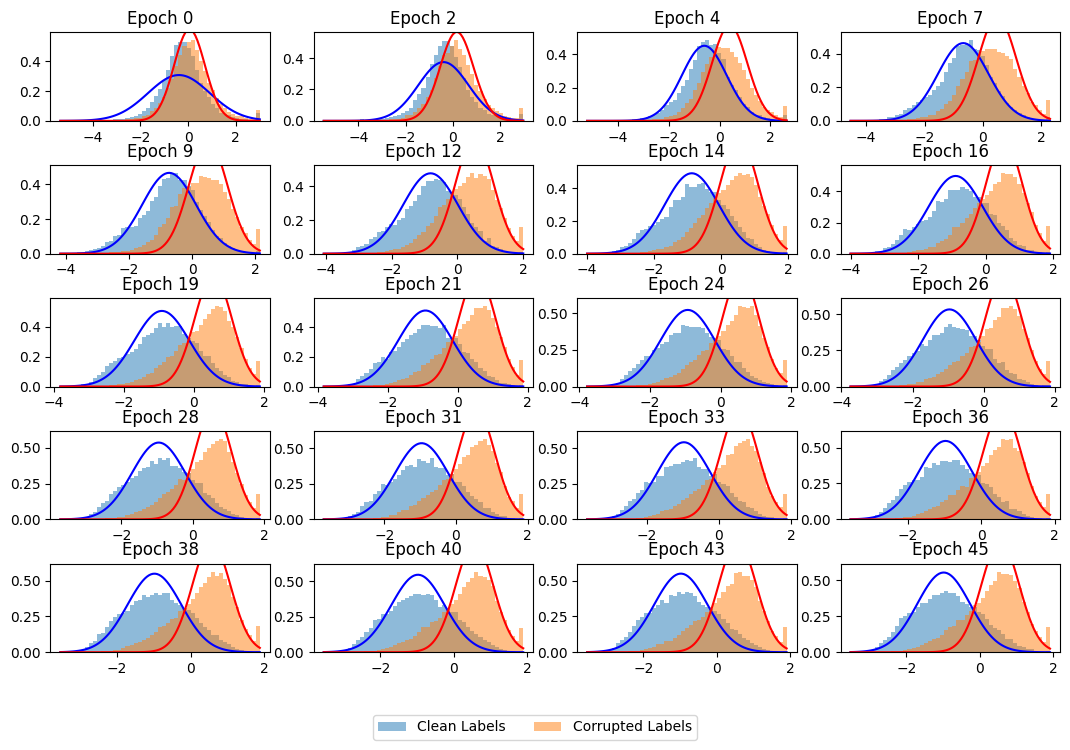

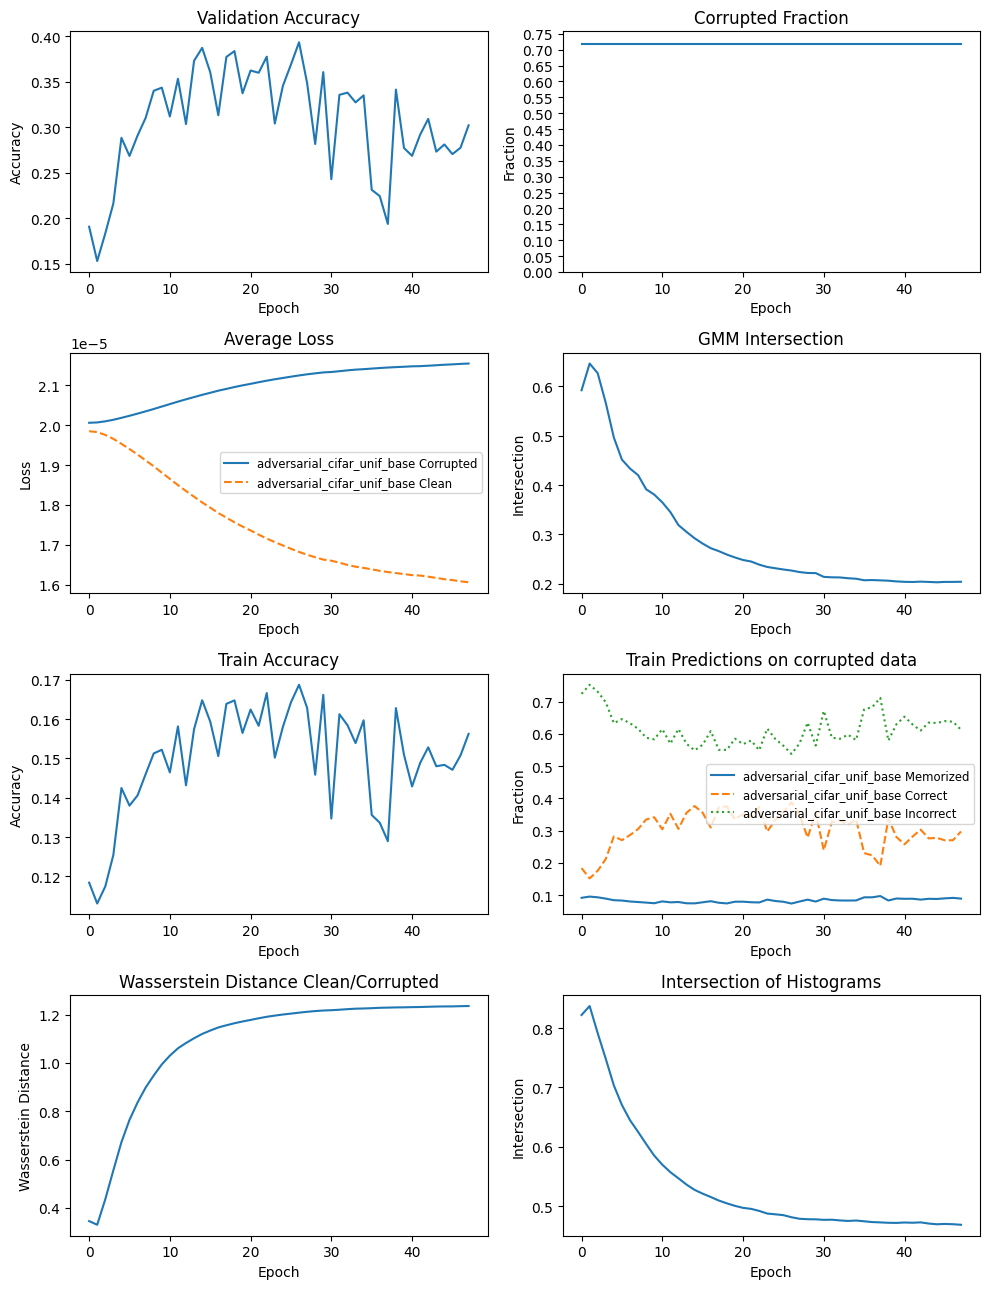

In [6]:
plot_insights('adversarial_cifar_unif_base')

In [ ]:
def analyze_corrections(directory: str):
    data = np.load(f"outputs/{directory}/losses.npy")
    epochs = 0
    for i in range(data.shape[0]):
        if np.count_nonzero(data[i]) > 0:
            epochs += 1
            
    data = data[:epochs, :]
    
    true_labels = np.load(f'outputs/{directory}/true_labels.npy')
    corrupted_labels = np.load(f'outputs/{directory}/corrupted_labels.npy')
    labels_history = np.load(f'outputs/{directory}/labels_history.npy')[:epochs, :]
    val_accuracies = np.load(f'outputs/{directory}/val_accuracies.npy')[:epochs]
    train_accuracies = np.load(f'outputs/{directory}/train_accuracies.npy')[:epochs]
    train_predictions = np.load(f'outputs/{directory}/train_predictions.npy')[:epochs, :]
    is_corrupted = corrupted_labels != true_labels
    
    from torchvision import datasets, transforms
    dataset = datasets.MNIST(
        root='data',
        train=True,
        download=False,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    )
    
    
    epoch = 20
    scaled_data = data[epoch, :]
    clipped_data = np.clip(scaled_data, 0, np.quantile(scaled_data, 0.99))
    clipped_data = (clipped_data - np.mean(clipped_data)) / np.std(clipped_data)
    
    correct = np.where((train_predictions[epoch] == true_labels) & (labels_history[epoch] != true_labels))[0]
    misclassified = np.where((train_predictions[epoch] != true_labels) & (labels_history[epoch] != true_labels))[0]
    incorrect = np.where((train_predictions[epoch] != true_labels) & (labels_history[epoch] == true_labels))[0]
    
    fig, ax = plt.subplots(20, 3, figsize=(10, 40))
    for i in range(20):
        ax[i, 0].imshow(dataset.data[correct[i]], cmap='gray')
        ax[i, 0].set_title(f"True: {true_labels[correct[i]]}, Pred: {train_predictions[epoch][correct[i]]}, Corrupted: {labels_history[epoch][correct[i]]}")
        ax[i, 0].axis('off')
        
        ax[i, 1].imshow(dataset.data[misclassified[i]].numpy(), cmap='gray')
        ax[i, 1].set_title(f"True: {true_labels[misclassified[i]]}, Pred: {train_predictions[epoch][misclassified[i]]}, Corrupted: {labels_history[epoch][misclassified[i]]}")
        ax[i, 1].axis('off')
        
        ax[i, 2].imshow(dataset.data[incorrect[i]].numpy(), cmap='gray')
        ax[i, 2].set_title(f"True: {true_labels[incorrect[i]]}, Pred: {train_predictions[epoch][incorrect[i]]}, Corrupted: {labels_history[epoch][incorrect[i]]}")
        ax[i, 2].axis('off')
    plt.tight_layout()
    plt.show()
        
    
    for epoch in range(epochs):
    
        corruption_matrix = np.zeros((len(np.unique(true_labels)), len(np.unique(true_labels))))
        for i in range(len(true_labels)):
            corruption_matrix[true_labels[i], int(labels_history[epoch, i])] += 1
        corruption_matrix /= corruption_matrix.sum(axis=1, keepdims=True)
        
        import seaborn as sns
        plt.figure(figsize=(8, 6))
        sns.heatmap(corruption_matrix, annot=True, fmt=".2f", cmap='Blues')
        plt.title(f"Corruption Matrix at Epoch {epoch}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()
        
        
analyze_corrections('adversarial_mnist_flip_gmm')